In [4]:
import numpy as np
import cv2
from tifffile import imread, imwrite
from pathlib import Path
import logging
from satellite_image_padder import SatelliteImagePadder, logger
from concurrent.futures import ThreadPoolExecutor
import rasterio
from rasterio.transform import Affine

PADATA_DIR = Path("pdata") 
TARGET_SIZE = (256, 256)
PADDING_MODE = "zero"  
ALIGNMENT = "center"         # Выравнивание (top_left, bottom_right, center)
logger.setLevel(logging.WARNING)

padder = SatelliteImagePadder(default_target_size=TARGET_SIZE)

def process_file(file_path, output_dir, padder, mode, alignment):
    try:
        image = imread(file_path)
        image = np.transpose(image, (2, 0, 1))

        padded_image, padding_mask = padder.pad(image, mode=mode, alignment=alignment)

        out_path = output_dir / file_path.name
        C, H, W = padded_image.shape
        
        with rasterio.open(
            out_path,
            'w',
            driver='GTiff',
            height=H,
            width=W,
            count=C,
            dtype=str(padded_image.dtype),
            crs=None,
            transform=Affine.identity()
        ) as dst:
            for i in range(C):
                dst.write(padded_image[i, :, :], i + 1)

        mask_out_path = output_dir / f"{file_path.stem}_padmask.tiff"
        with rasterio.open(
            mask_out_path,
            'w',
            driver='GTiff',
            height=H,
            width=W,
            count=1,
            dtype='uint8',
            crs=None,
            transform=Affine.identity()
        ) as dst:
            dst.write(padding_mask, 1)

    except Exception as e:
        logger.error(f"Ошибка при обработке файла {file_path}: {e}")

def process_images(input_dir, output_dir, padder, mode, alignment):
    if not input_dir.exists():
        logger.warning(f"Директория {input_dir} не найдена, пропускаем.")
        return

    output_dir.mkdir(exist_ok=True)
    files = list(input_dir.glob("*.tiff"))

    with ThreadPoolExecutor() as executor:
        executor.map(
            lambda f: process_file(f, output_dir, padder, mode, alignment),
            files
        )

for field_dir in PADATA_DIR.iterdir():
    if not field_dir.is_dir():
        continue

    for date_dir in field_dir.iterdir():
        if not date_dir.is_dir():
            continue

        logger.info(f"Обрабатываем: {date_dir}")

        optical_input_dir = date_dir / "raw_imgs_optical"
        optical_output_dir = date_dir / f"padded_optical_{PADDING_MODE}"
        process_images(optical_input_dir, optical_output_dir, padder, PADDING_MODE, ALIGNMENT)

        sar_input_dir = date_dir / "raw_imgs_sar"
        sar_output_dir = date_dir / f"padded_sar_{PADDING_MODE}"
        process_images(sar_input_dir, sar_output_dir, padder, PADDING_MODE, ALIGNMENT)

print("Готово! Все изображения паддинговые и сохранены.")

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Готово! Все изображения паддинговые и сохранены.


In [4]:
import numpy as np
import rasterio
from pathlib import Path

def print_image_info(image_path: Path):
    """
    Выводит подробную информацию о TIFF-изображении.
    Включает метаданные и статистику по каждому каналу.
    """
    print(f"Файл: {image_path}")
    try:
        with rasterio.open(image_path) as src:
            data = src.read()  # shape = (bands, height, width)
            print(f"  Драйвер: {src.driver}")
            print(f"  CRS: {src.crs}")
            print(f"  Transform: {src.transform}")
            print(f"  Размер: {src.width} x {src.height}")
            print(f"  Количество каналов: {src.count}")
            print(f"  Тип данных: {data.dtype}")
            for band in range(src.count):
                band_data = data[band]
                band_min = np.nanmin(band_data)
                band_max = np.nanmax(band_data)
                band_mean = np.nanmean(band_data)
                band_std = np.nanstd(band_data)
                print(f"  Канал {band+1}: min={band_min}, max={band_max}, mean={band_mean:.3f}, std={band_std:.3f}")
            print("-" * 60)
    except Exception as e:
        print(f"Ошибка при чтении {image_path}: {e}")

def print_transformed_info(image_path: Path, epsilon=1e-8):
    """
    Применяет преобразование 10 * log10(data + epsilon) и выводит статистику для каждого канала.
    Это полезно для анализа SAR-снимков, если они должны быть в децибелах.
    """
    #print(f"Преобразованное (dB) для файла: {image_path}")
    try:
        with rasterio.open(image_path) as src:
            data = src.read().astype(np.float32)
            # Применяем логарифмическое преобразование: 10*log10(data + epsilon)
            data_db = 10 * np.log10(data)
            for band in range(src.count):
                band_data = data_db[band]
                band_min = np.nanmin(band_data)
                band_max = np.nanmax(band_data)
                band_mean = np.nanmean(band_data)
                band_std = np.nanstd(band_data)
                print(f"  Канал {band+1} (dB): min={band_min:.3f}, max={band_max:.3f}, mean={band_mean:.3f}, std={band_std:.3f}")
            print("-" * 60)
    except Exception as e:
        print(f"Ошибка при преобразовании {image_path}: {e}")

def scan_directory(directory: Path, transform=False, limit=50):
    """
    Рекурсивно сканирует директорию и выводит информацию для первых limit TIFF-файлов.
    Если transform=True, дополнительно выводит статистику после логарифмического преобразования.
    """
    tiff_files = list(directory.rglob("*.tif*"))
    limited_files = tiff_files[:limit]
    print(f"Найдено {len(tiff_files)} TIFF файлов в {directory}. Вывод информации для первых {len(limited_files)} файлов.\n")
    for file in limited_files:
        print_image_info(file)
        if transform:
            print_transformed_info(file)

if __name__ == "__main__":
    raw_images_dir = Path("clouds/s1")
    scan_directory(raw_images_dir, transform=True, limit=20)

Найдено 122218 TIFF файлов в clouds/s1. Вывод информации для первых 20 файлов.

Файл: clouds/s1/ROIs1158_spring_1_p306.tif
  Драйвер: GTiff
  CRS: EPSG:32737
  Transform: | 10.00, 0.00, 394612.34|
| 0.00,-10.00, 8105222.84|
| 0.00, 0.00, 1.00|
  Размер: 256 x 256
  Количество каналов: 2
  Тип данных: float32
  Канал 1: min=-19.630796432495117, max=-0.9753064513206482, mean=-10.894, std=1.956
  Канал 2: min=-27.337907791137695, max=-9.513772964477539, mean=-16.811, std=2.125
------------------------------------------------------------
  Канал 1 (dB): min=nan, max=nan, mean=nan, std=nan
  Канал 2 (dB): min=nan, max=nan, mean=nan, std=nan
------------------------------------------------------------
Файл: clouds/s1/ROIs1158_spring_1_p504.tif
  Драйвер: GTiff
  CRS: EPSG:32737
  Transform: | 10.00, 0.00, 388212.34|
| 0.00,-10.00, 8096262.84|
| 0.00, 0.00, 1.00|
  Размер: 256 x 256
  Количество каналов: 2
  Тип данных: float32
  Канал 1: min=-20.668689727783203, max=-1.6673589944839478, mean

/tmp/ipykernel_528749/2225551689.py:41: RuntimeWarning: invalid value encountered in log10
  data_db = 10 * np.log10(data)
/tmp/ipykernel_528749/2225551689.py:44: RuntimeWarning: All-NaN slice encountered
  band_min = np.nanmin(band_data)
/tmp/ipykernel_528749/2225551689.py:45: RuntimeWarning: All-NaN slice encountered
  band_max = np.nanmax(band_data)
/tmp/ipykernel_528749/2225551689.py:46: RuntimeWarning: Mean of empty slice
  band_mean = np.nanmean(band_data)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_528749/2225551689.py:41: RuntimeWarning: divide by zero encountered in log10
  data_db = 10 * np.log10(data)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


In [5]:
if __name__ == "__main__":
    raw_images_dir = Path("clouds/s2_cloudy")
    scan_directory(raw_images_dir, transform=True, limit=20)

Найдено 122218 TIFF файлов в clouds/s2_cloudy. Вывод информации для первых 20 файлов.

Файл: clouds/s2_cloudy/ROIs1158_spring_15_p258.tif
  Драйвер: GTiff
  CRS: EPSG:32756
  Transform: | 10.00, 0.00, 332700.44|
| 0.00,-10.00, 7289866.58|
| 0.00, 0.00, 1.00|
  Размер: 256 x 256
  Количество каналов: 13
  Тип данных: uint16
  Канал 1: min=1279, max=6370, mean=1991.737, std=1101.852
  Канал 2: min=865, max=6909, mean=1741.937, std=1232.668
  Канал 3: min=564, max=6824, mean=1599.663, std=1241.377
  Канал 4: min=354, max=7380, mean=1489.604, std=1409.115
  Канал 5: min=401, max=7304, mean=1757.860, std=1344.724
  Канал 6: min=504, max=7862, mean=2660.906, std=1305.462
  Канал 7: min=566, max=8285, mean=3047.840, std=1344.828
  Канал 8: min=419, max=8001, mean=2909.459, std=1280.262
  Канал 9: min=514, max=8672, mean=3374.206, std=1379.084
  Канал 10: min=149, max=1957, mean=584.213, std=338.233
  Канал 11: min=6, max=26, mean=12.362, std=3.011
  Канал 12: min=414, max=7220, mean=2650.528,

In [6]:
if __name__ == "__main__":
    raw_images_dir = Path("pdata/0127/0127 2024-01-01/raw_imgs_sar")
    scan_directory(raw_images_dir, transform=True, limit=20)

Найдено 114 TIFF файлов в pdata/0127/0127 2024-01-01/raw_imgs_sar. Вывод информации для первых 20 файлов.

Файл: pdata/0127/0127 2024-01-01/raw_imgs_sar/SAR_pair_0_20231122_0309.tiff
  Драйвер: GTiff
  CRS: EPSG:4326
  Transform: | 10.00, 0.00, 0.00|
| 0.00,-10.00, 0.00|
| 0.00, 0.00, 1.00|
  Размер: 78 x 134
  Количество каналов: 2
  Тип данных: float32
  Канал 1: min=-60.0, max=5.86023473739624, mean=-11.291, std=4.452
  Канал 2: min=-60.0, max=-6.252169609069824, mean=-20.813, std=9.104
------------------------------------------------------------
  Канал 1 (dB): min=-17.224, max=7.679, mean=0.065, std=4.694
  Канал 2 (dB): min=nan, max=nan, mean=nan, std=nan
------------------------------------------------------------
Файл: pdata/0127/0127 2024-01-01/raw_imgs_sar/SAR_pair_1_20230923_0309.tiff
  Драйвер: GTiff
  CRS: EPSG:4326
  Transform: | 10.00, 0.00, 0.00|
| 0.00,-10.00, 0.00|
| 0.00, 0.00, 1.00|
  Размер: 78 x 134
  Количество каналов: 2
  Тип данных: float32
  Канал 1: min=-40.

/tmp/ipykernel_528749/2225551689.py:41: RuntimeWarning: invalid value encountered in log10
  data_db = 10 * np.log10(data)
/tmp/ipykernel_528749/2225551689.py:44: RuntimeWarning: All-NaN slice encountered
  band_min = np.nanmin(band_data)
/tmp/ipykernel_528749/2225551689.py:45: RuntimeWarning: All-NaN slice encountered
  band_max = np.nanmax(band_data)
/tmp/ipykernel_528749/2225551689.py:46: RuntimeWarning: Mean of empty slice
  band_mean = np.nanmean(band_data)


In [12]:
if __name__ == "__main__":
    raw_images_dir = Path("pdata/0127/0127 2024-01-01/padded_imgs_sar")
    scan_directory(raw_images_dir, transform=True, limit=20)

Найдено 0 TIFF файлов в pdata/0127/0127 2024-01-01/padded_imgs_sar. Вывод информации для первых 0 файлов.



In [21]:
import os
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import rasterio
import re
from datetime import datetime, timedelta
import shutil

def get_rescaled_data(data, limits):
    """
    Линейно масштабируем значение data в диапазон [0..1] на основе заданных limits=[min, max].
    Все, что меньше min, прижмется к 0, что больше max — к 1.
    """
    out = (data - limits[0]) / (limits[1] - limits[0])
    out = np.clip(out, 0.0, 1.0)
    return out

def get_normalized_difference(channel1, channel2):
    """
    Возвращает (channel1 - channel2)/(channel1 + channel2).
    Если (channel1 + channel2)==0, то делитель заменим на маленькую константу.
    """
    sub_ = channel1 - channel2
    sum_ = channel1 + channel2
    sum_[sum_ == 0] = 1e-6
    return sub_ / sum_

def get_shadow_mask(data_image):
    """
    Пример простейшей оценки теней (shadow). Возвращает 2D-массив, где -1=тень, 0=нет тени.
    Ориентируемся на Blue (B2), NIR (B8) и SWIR1 (B12 для Sentinel2, но здесь index=11).
    """
    data_image = data_image / 10000.0
    ch, r, c = data_image.shape
    shadow_mask = np.zeros((r, c), dtype='float32')

    # Blue = data_image[1], NIR=data_image[7], SWIR1=data_image[11] (Sentinel-2)
    BB = data_image[1]
    BNIR = data_image[7]
    BSWIR1 = data_image[11]

    # CSI = среднее (NIR+SWIR1)/2
    CSI = (BNIR + BSWIR1) / 2.0
    # Порог T3
    t3 = 3/4
    T3 = np.min(CSI) + t3 * (np.mean(CSI) - np.min(CSI))

    # Порог T4
    t4 = 5/6
    T4 = np.min(BB) + t4 * (np.mean(BB) - np.min(BB))

    # Условие тени
    shadow_tf = np.logical_and(CSI < T3, BB < T4)
    shadow_mask[shadow_tf] = -1

    return shadow_mask

def get_cloud_mask(data_image, cloud_threshold=0.2, binarize=True):
    """
    Возвращает 2D-карту "score" или бинарную карту (1=облако, 0=небо).
    data_image ожидается в калибровке [0..10000] до деления.
    """
    data_norm = data_image / 10000.0
    ch, r, c = data_norm.shape
    score = np.ones((r, c), dtype='float32')

    # 1) Ограничим BLUE в [0.1..0.5]
    score = np.minimum(score, get_rescaled_data(data_norm[1], [0.1, 0.5]))
    # 2) Ограничим COASTAL в [0.1..0.3] - условно data_norm[0]
    score = np.minimum(score, get_rescaled_data(data_norm[0], [0.1, 0.3]))
    # 3) sum of Red+Green+Blue
    RGB_sum = data_norm[3] + data_norm[2] + data_norm[1]
    score = np.minimum(score, get_rescaled_data(RGB_sum, [0.2, 0.8]))

    # 4) NDSI = (Green - SWIR1)/(Green + SWIR1)
    ndsi = get_normalized_difference(data_norm[2], data_norm[11])
    score = np.minimum(score, get_rescaled_data(ndsi, [0.8, 0.6]))  # инверсия порога

    if binarize:
        # Бинаризуем по cloud_threshold
        cloud_bin = np.zeros_like(score, dtype='uint8')
        cloud_bin[score >= cloud_threshold] = 0
        cloud_bin[score < cloud_threshold] = 1
        return cloud_bin
    else:
        # Возвращаем непрерывную карту score
        return score

def get_cloud_cloudshadow_mask(data_image, cloud_threshold=0.2):
    """
    Совмещаем облака и тени.
    Возвращает 2D np.array с:
     1 = облако
    -1 = тень
     0 = чистый пиксель
    """
    cloud_bin = get_cloud_mask(data_image, cloud_threshold=cloud_threshold, binarize=True)
    shadow_bin = get_shadow_mask(data_image)  # -1=тень, 0=нет
    out = np.zeros_like(cloud_bin, dtype='int8')

    out[shadow_bin < 0] = -1
    out[cloud_bin == 1] = 1
    return out

SAR_DB_CLIP_MIN = [-25.0, -32.5]
SAR_DB_CLIP_MAX = [0.0, 0.0]

def normalize_sar(sar_data: np.ndarray) -> np.ndarray:
    sar_data = np.nan_to_num(sar_data, nan=0.0)
    for ch in range(sar_data.shape[0]):
        min_val = SAR_DB_CLIP_MIN[ch]
        max_val = SAR_DB_CLIP_MAX[ch]
        band = np.clip(sar_data[ch], min_val, max_val)
        rng = (max_val - min_val) if (max_val - min_val) != 0 else 1e-8
        sar_data[ch] = (band - min_val) / rng
    return sar_data

def normalize_optical(opt_data: np.ndarray) -> np.ndarray:
    opt_data = np.nan_to_num(opt_data, nan=0.0)
    opt_data /= 10000.0
    return opt_data

PADATA_DIR = Path("pdata")
OPTICAL_DIR_NAME = "padded_optical_zero"
SAR_DIR_NAME = "padded_sar_zero"
SAVE_DIR = Path("./test_kras")
SAVE_DIR.mkdir(exist_ok=True)

DATE_REGEX = re.compile(r"\d{8}")

class CustomDataset(Dataset):
    def __init__(self, base_dir: Path, cloud_threshold=0.2):
        self.samples = []
        self.cloud_threshold = cloud_threshold

        for field_dir in base_dir.iterdir():
            if not field_dir.is_dir():
                continue

            subdirs = [d for d in field_dir.iterdir() if d.is_dir()]
            if not subdirs:
                print(f"⚠️ Пропускаем поле {field_dir}: нет данных")
                continue

            latest_data_dir = subdirs[0]
            optical_dir = latest_data_dir / OPTICAL_DIR_NAME
            sar_dir = latest_data_dir / SAR_DIR_NAME
            if not optical_dir.exists() or not sar_dir.exists():
                print(f"⚠️ Пропускаем {latest_data_dir}: нет {OPTICAL_DIR_NAME} или {SAR_DIR_NAME}")
                continue

            # Собираем SAR-файлы
            sar_files = [f for f in sar_dir.glob("*.tiff") if "_padmask.tiff" not in f.name]
            sar_dates = {}
            for sar_file in sar_files:
                match = DATE_REGEX.search(sar_file.name)
                if match:
                    sar_date = datetime.strptime(match.group(), "%Y%m%d")
                    sar_dates[sar_date] = sar_file

            if not sar_dates:
                print(f"⚠️ В {sar_dir} нет SAR-файлов с датами (или остались только маски)")
                continue

            # Сопоставляем оптические с SAR по ближайшей дате (±3 дня)
            optical_files = [f for f in optical_dir.glob("*.tiff") if "_padmask.tiff" not in f.name]
            for opt_file in optical_files:
                match = DATE_REGEX.search(opt_file.name)
                if not match:
                    continue
                opt_date = datetime.strptime(match.group(), "%Y%m%d")
                best_sar_file = None
                best_sar_delta = timedelta(days=4)
                for sar_date, sar_file in sar_dates.items():
                    delta = abs(opt_date - sar_date)
                    if delta <= timedelta(days=3) and delta < best_sar_delta:
                        best_sar_file = sar_file
                        best_sar_delta = delta

                if best_sar_file:
                    self.samples.append({
                        'opt_file': opt_file,
                        'sar_file': best_sar_file,
                        'opt_var': 'zero',
                        'field_name': field_dir.name,
                        'date_name': latest_data_dir.name
                    })
                else:
                    print(f"⚠️ Нет подходящего SAR для {opt_file.name}")
        
        assert len(self.samples) > 0, "🚨 Ошибка: Не найдено ни одной пары Optical + SAR!"

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        opt_path = sample["opt_file"]
        sar_path = sample["sar_file"]

        with rasterio.open(opt_path) as src:
            cloudy_data_raw = src.read(indexes=range(1,14)).astype(np.float32)

        cloud_mask = get_cloud_cloudshadow_mask(
            data_image=cloudy_data_raw.copy(),
            cloud_threshold=self.cloud_threshold
        )

        cloudy_data = normalize_optical(cloudy_data_raw)

        with rasterio.open(sar_path) as src:
            SAR_data_raw = src.read().astype(np.float32)
        if SAR_data_raw.shape[0] < 2:
            pad_ch = 2 - SAR_data_raw.shape[0]
            add_zeros = np.zeros((pad_ch, SAR_data_raw.shape[1], SAR_data_raw.shape[2]), dtype=np.float32)
            SAR_data_raw = np.concatenate([SAR_data_raw, add_zeros], axis=0)
        elif SAR_data_raw.shape[0] > 2:
            SAR_data_raw = SAR_data_raw[:2]
        SAR_data = normalize_sar(SAR_data_raw)

        if cloudy_data.shape[0] < 13:
            pad_ch = 13 - cloudy_data.shape[0]
            add_zeros = np.zeros((pad_ch, cloudy_data.shape[1], cloudy_data.shape[2]), dtype=np.float32)
            cloudy_data = np.concatenate([cloudy_data, add_zeros], axis=0)
        elif cloudy_data.shape[0] > 13:
            cloudy_data = cloudy_data[:13]

        return {
            "cloudy_data": torch.tensor(cloudy_data),
            "SAR_data": torch.tensor(SAR_data),
            "cloud_mask": torch.tensor(cloud_mask, dtype=torch.int8),
            "file_name": opt_path.name,
            "opt_var": sample["opt_var"],
            "field_name": sample["field_name"],
            "date_name": sample["date_name"],
            "opt_path": str(opt_path),
            "sar_path": str(sar_path)
        }


def run_test_custom(CR_net, dataloader, save_dir=None):
    """
    Запускаем модель, сохраняем:
      1) _pred.tif (восстановленная оптика)
      2) cloud_mask.tif (облачная маска)
      3) при наличии padmask копируем её тоже
    """
    CR_net.eval()
    
    if save_dir is None:
        save_dir = "./test_saved"
    os.makedirs(save_dir, exist_ok=True)
    
    pbar = tqdm(dataloader, desc="Тестирование", ncols=100)
    
    with torch.no_grad():
        count = 0
        for batch in pbar:
            cloudy_data = batch['cloudy_data'].cuda()  # (B,13,H,W)
            SAR_data = batch['SAR_data'].cuda()        # (B,2,H,W)
            cloud_mask_batch = batch['cloud_mask']     # (B,H,W) (int8)
            file_names = batch['file_name']
            opt_vars = batch['opt_var']
            field_names = batch['field_name']
            date_names = batch['date_name']
            opt_paths = batch['opt_path']
            sar_paths = batch['sar_path']

            pred_cloudfree_data = CR_net(cloudy_data, SAR_data)  # (B,13,H,W)

            # 2) clamp(0..1)
            pred_cloudfree_data = torch.clamp(pred_cloudfree_data, 0.0, 1.0)

            B_now = cloudy_data.size(0)
            for b_i in range(B_now):
                base_name = file_names[b_i].replace(".tiff", "")
                field_name = field_names[b_i]
                date_name = date_names[b_i]
                opt_var = opt_vars[b_i]  # 'zero'
                
                out_dir = Path(save_dir) / field_name / date_name / f"results_{opt_var}"
                out_dir.mkdir(parents=True, exist_ok=True)
                
                out_pred = out_dir / f"{base_name}_pred.tif"
                pred_np = pred_cloudfree_data[b_i].cpu().numpy()  # shape=(13,H,W)
                
                with rasterio.open(
                    out_pred,
                    'w',
                    driver='GTiff',
                    height=pred_np.shape[1],
                    width=pred_np.shape[2],
                    count=pred_np.shape[0],
                    dtype='float32'
                ) as dst:
                    for ch_i in range(pred_np.shape[0]):
                        dst.write(pred_np[ch_i].astype(np.float32), ch_i+1)

                cloud_mask_np = cloud_mask_batch[b_i].numpy()  # (H,W), int8

                out_mask = out_dir / f"{base_name}_cloudmask.tif"
                with rasterio.open(
                    out_mask,
                    'w',
                    driver='GTiff',
                    height=cloud_mask_np.shape[0],
                    width=cloud_mask_np.shape[1],
                    count=1,
                    dtype='int8'
                ) as dst:
                    dst.write(cloud_mask_np, 1)
                
                opt_file_path = Path(opt_paths[b_i])
                mask_name = opt_file_path.stem + "_padmask.tiff"
                mask_path = opt_file_path.parent / mask_name
                if mask_path.exists():
                    shutil.copy2(mask_path, out_dir / mask_path.name)
                else:
                    print(f"⚠️ Маска для {opt_file_path.name} не найдена (ожидалась {mask_name}).")

            count += B_now
            pbar.set_postfix({'Processed': count})

    print(f"Тестирование завершено! Обработано {count} образцов. Результаты в {save_dir}")

from glf_test import RDN_residual_CR

def main():
    print("Загружаем модель...")
    
    net = RDN_residual_CR(256).cuda()
    checkpoint_path = "./checkpoints/29_net_CR.pth"
    checkpoint = torch.load(checkpoint_path)
    
    def remove_module_prefix(state_dict):
        return {k.replace("module.", ""): v for k, v in state_dict.items()}
    
    net.load_state_dict(remove_module_prefix(checkpoint["network"]))
    net.eval()

    dataset = CustomDataset(
        base_dir=PADATA_DIR, 
        cloud_threshold=0.2
    )
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=8)
    
    run_test_custom(net, dataloader, save_dir=SAVE_DIR)

if __name__ == "__main__":
    main()

Загружаем модель...


Тестирование: 100%|█████████████████████████████| 1696/1696 [03:24<00:00,  8.28it/s, Processed=1696]

Тестирование завершено! Обработано 1696 образцов. Результаты в test_kras


In [22]:
import rasterio
import numpy as np
from pathlib import Path
import os
import shutil

from satellite_image_padder import SatelliteImagePadder

padder = SatelliteImagePadder(default_target_size=256)

def remove_padding_3d(pred_path: Path, mask_path: Path, output_path: Path):
    """
    Считывает предсказанный 3D TIFF (C,H,W) и однослойную пад-маску (H,W).
    Удаляет паддинг и сохраняет результат в output_path (3D-данные).
    """
    with rasterio.open(pred_path) as src:
        pred_data = src.read().astype(np.float32)  # shape=(C,H,W)

    with rasterio.open(mask_path) as src:
        pad_mask = src.read(1).astype(np.uint8)    # shape=(H,W)

    cropped_data = padder.postprocess(pred_data, pad_mask)
    
    C, H, W = cropped_data.shape
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=H,
        width=W,
        count=C,
        dtype='float32'
    ) as dst:
        for i in range(C):
            dst.write(cropped_data[i], i + 1)

def remove_padding_2d(mask_path_in: Path, padmask_path: Path, output_path: Path):
    """
    Аналогичная функция для 2D-данных (например, облачной маски).
    Считывает (H,W), обрезает паддинг по pad_mask, сохраняет (H',W').
    """
    with rasterio.open(mask_path_in) as src:
        mask_data = src.read(1).astype(np.int16)

    with rasterio.open(padmask_path) as src_pad:
        pad_mask = src_pad.read(1).astype(np.uint8)

    # mask_data.shape=(H,W)
    mask_data_3d = mask_data[np.newaxis, ...]  # (1,H,W)

    cropped_3d = padder.postprocess(mask_data_3d, pad_mask)
    cropped_2d = cropped_3d[0]  # (H',W')

    H, W = cropped_2d.shape
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=H,
        width=W,
        count=1,
        dtype='int16'
    ) as dst:
        dst.write(cropped_2d, 1)


def main():
    results_dir = Path("./test_kras")
    
    cropped_dir = Path("./test_kras_cropped")
    cropped_dir.mkdir(exist_ok=True)

    pred_files = list(results_dir.rglob("*_pred.tif"))

    for pred_file in pred_files:
        rel_path = pred_file.relative_to(results_dir)  

        new_parent = cropped_dir / rel_path.parent  
        new_parent.mkdir(parents=True, exist_ok=True)

        out_file = new_parent / (pred_file.stem + "_cropped.tif")

        stem = pred_file.stem.replace("_pred", "")  
        padmask_name = stem + "_padmask.tiff"
        padmask_path = pred_file.parent / padmask_name

        if not padmask_path.exists():
            print(f"⚠️ Маска {padmask_path} не найдена, пропускаем обрезание _pred.")
            continue

        remove_padding_3d(pred_path=pred_file, mask_path=padmask_path, output_path=out_file)

        cloudmask_name = stem + "_cloudmask.tif"  # например "myimage_cloudmask.tif"
        cloudmask_path = pred_file.parent / cloudmask_name

        if cloudmask_path.exists():
            cloudmask_out = new_parent / (cloudmask_path.stem + "_cropped.tif")
            remove_padding_2d(mask_path_in=cloudmask_path,
                              padmask_path=padmask_path,
                              output_path=cloudmask_out)
        else:
            pass

    print(f"Готово! Все обрезанные TIFF сохранены в {cropped_dir} со структурой подпапок.")


if __name__ == "__main__":
    main()

Готово! Все обрезанные TIFF сохранены в test_kras_cropped со структурой подпапок.


In [10]:
import os
import numpy as np
import rasterio
from pathlib import Path

NORMAL_RANGES = {
    #    Теоретически -1..+1; для растительности чаще отрицательные/около 0, 
    #    поверхностная вода может давать высокие положительные. 
    #    Условно возьмём «приемлемый» диапазон:
    "NDWI": (-1.0, 1.0),

    #    Аналогично -1..+1. При «здоровой» растительности обычно от 0 до 0.6, 
    #    но бывает и за пределами. Примем:
    "NDMI": (-1.0, 1.0),

    #    Теория: -1..+1, но для растительности обычно 0..1. 
    #    Если хотим «разумные» рамки, ставим:
    "NDVI": (0.0, 1.0),

    #    Может сильно варьировать: от <1 (слабая растительность) до >10 (очень плотная). 
    #    Часто ~1..8 «встречается». Для условной "нормы" возьмём:
    "SR": (0.0, 10.0),

    #    Типичные значения для «здоровой» листвы ~ 700..730 нм.
    "REP": (680.0, 750.0),

    #    Теоретически может быть немного > 2. Обычно -1..+1.5 
    #    «Здоровая растительность» часто 0..~1.3. Возьмём:
    "EVI": (0.0, 2.0),

    #    Похожие рамки, -1..~2. Условно:
    "EVI2": (0.0, 2.0),

    #    -1..+1 (по аналогии с NDVI). Возьмём:
    "ARVI": (-1.0, 1.0),

    #    Аналог NDVI, тоже -1..+1, для «зелёных» значений 0..1. 
    "SAVI": (-1.0, 1.0),

    #     Как правило, может быть в районе -1..+1. Чаще около 0..1 для растительности.
    "GOSAVI": (-1.0, 1.0),

    #     Тоже может варьировать ~ -1..+1. 
    "GARI": (-1.0, 1.0),

    #     Тоже обычно ~ -1..+1.
    "VARI": (-1.0, 1.0),
}

def safe_div(num: np.ndarray, den: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """
    Безопасное деление: num/(den+eps), чтобы избежать деления на 0.
    """
    return num / (den + eps)

def calc_veg_indices(pred_data: np.ndarray) -> dict:
    """
    pred_data: (13,H,W) после инференса, значения ~ [0..1].
    Возвращает словарь с индексами (пример: NDVI, EVI, EVI2, ARVI...).
    """

    B01 = pred_data[0]  # Примерно 443 nm
    B02 = pred_data[1]  # Blue
    B03 = pred_data[2]  # Green
    B04 = pred_data[3]  # Red
    B05 = pred_data[4]
    B06 = pred_data[5]
    B07 = pred_data[6]
    B08 = pred_data[7]  # NIR
    B8A = pred_data[8]
    B09 = pred_data[9]
    B11 = pred_data[10] # SWIR1
    B12 = pred_data[11] # SWIR2

    NDWI = safe_div(B03 - B08, B03 + B08)
    NDMI = safe_div(B08 - B11, B08 + B11)
    NDVI = safe_div(B08 - B04, B08 + B04)
    SR   = safe_div(B08, B04)

    REP_num = ((B04 + B07)/2.) - B05
    REP_den = (B06 - B05)
    REP = 700. + 40. * safe_div(REP_num, REP_den)

    # EVI
    G, C1, C2, L = 2.5, 6.0, 7.5, 1.0
    EVI = G * safe_div((B08 - B04), (B08 + C1*B04 - C2*B02 + L))
    EVI2= 2.5 * safe_div((B08 - B04), (B08 + B04 + 1.0))

    # ARVI
    ARVI_num = B8A - (2.0*B04 - B02)
    ARVI_den = B8A + (2.0*B04 - B02)
    ARVI= safe_div(ARVI_num, ARVI_den)

    # SAVI
    L_savi= 0.5
    SAVI = (safe_div((B08 - B04), (B08 + B04 + L_savi))) * (1.0 + L_savi)

    GOSAVI= safe_div((B08 - B03), (B08 + B03 + 0.16))

    GARI_num= B08 - (B03 - B02 + B04)
    GARI_den= B08 + (B03 - B02 + B04)
    GARI= safe_div(GARI_num, GARI_den)

    VARI_num= (B03 - B04)
    VARI_den= (B03 + B04 - B02)
    VARI_ = safe_div(VARI_num, VARI_den)

    return {
        "NDWI": NDWI,
        "NDMI": NDMI,
        "NDVI": NDVI,
        "SR": SR,
        "REP": REP,
        "EVI": EVI,
        "EVI2": EVI2,
        "ARVI": ARVI,
        "SAVI": SAVI,
        "GOSAVI": GOSAVI,
        "GARI": GARI,
        "VARI": VARI_
    }

def is_spoiled_index(index_name: str, index_array: np.ndarray) -> bool:
    """
    Смотрим, выходит ли СРЕДНЕЕ значение (или медиана) за предустановленные "нормальные" рамки.
    Возвращает True, если индекс бракован (т.е. не в норме).
    """
    if index_name not in NORMAL_RANGES:
        return False

    min_norm, max_norm = NORMAL_RANGES[index_name]
    mean_val = np.nanmean(index_array)
    if np.isnan(mean_val):
        return True

    if mean_val < min_norm or mean_val > max_norm:
        return True
    else:
        return False

def is_image_spoiled(idx_map: dict) -> bool:
    """
    Если хотя бы один индекс "вышел" за норму, считаем картинку бракованной.
    """
    for idx_name, idx_data in idx_map.items():
        if is_spoiled_index(idx_name, idx_data):
            return True
    return False

def find_cloud_mask(fpath: Path):
    """
    Ищем <stem>_cloudmask_cropped.tif, где <stem> = имя без суффикса "_pred_cropped".
    Возвращаем (cm, cloud_pct, shadow_pct) или (None, None, None).
    Тут cm: массив -1=тень,0=чисто,1=облако.
    И cloud_pct=(облако/всего)*100, shadow_pct аналогично.
    """
    stem = fpath.stem
    if stem.endswith("_pred_cropped"):
        stem = stem[:-len("_pred_cropped")]
    mask_path = fpath.parent / f"{stem}_cloudmask_cropped.tif"
    if not mask_path.exists():
        return (None, None, None)

    with rasterio.open(mask_path) as src:
        cm = src.read(1)
    total = cm.size
    c_pix = np.sum(cm == 1)
    s_pix = np.sum(cm == -1)
    cloud_pct  = 100.0 * c_pix / total
    shadow_pct = 100.0 * s_pix / total
    return (cm, cloud_pct, shadow_pct)

def bootstrap_conf_interval(data: np.ndarray, n_boot=300, alpha=0.05):
    """
    Возвращаем (mean, low, high) для 1D массива data,
    методом бутстрапа (с возвращением).
    """
    valid = data[~np.isnan(data)]
    if len(valid) < 2:
        return (np.nan, np.nan, np.nan)
    N = len(valid)
    means = []
    for _ in range(n_boot):
        sample = np.random.choice(valid, size=N, replace=True)
        means.append(np.mean(sample))
    means = np.array(means)
    low = np.percentile(means, 100.0*(alpha/2.0))
    high= np.percentile(means, 100.0*(1.0 - alpha/2.0))
    return (valid.mean(), low, high)

def process_directory(input_dir: Path):
    """
    1) Ищем "*_pred_cropped.tif" (13 каналов),
    2) Для каждой картинки считаем индексы,
    3) Проверяем, бракованная ли (is_image_spoiled),
    4) Считываем облачную маску -> % облачности,
    5) Сохраняем % облачности в массив good_cloud_percents или bad_cloud_percents,
    6) В конце строим доверительные интервалы по облачности для обеих групп.
    """

    good_cloud_percents = []
    bad_cloud_percents  = []

    files = list(input_dir.rglob("*_pred_cropped.tif"))
    if not files:
        print(f"Нет файлов *_pred_cropped.tif в {input_dir}")
        return

    for f in files:
        with rasterio.open(f) as src:
            if src.count != 13:
                continue
            data = src.read().astype(np.float32)

        # Считаем индексы
        idx_map = calc_veg_indices(data)

        # Определяем "брак"?
        spoiled = is_image_spoiled(idx_map)  # True/False

        # Читаем маску -> % cloud
        cm, c_pct, s_pct = find_cloud_mask(f)
        if cm is None:
            # Нет маски — пропустим
            continue

        # Сохраняем в подходящий массив
        if spoiled:
            bad_cloud_percents.append(c_pct)
        else:
            good_cloud_percents.append(c_pct)

    # Итого два массива
    print("\n===== Результаты =====")
    print(f"Нормальных снимков: {len(good_cloud_percents)}")
    print(f"Бракованных снимков: {len(bad_cloud_percents)}")

    arr_good = np.array(good_cloud_percents, dtype=float)
    arr_bad  = np.array(bad_cloud_percents, dtype=float)

    # Доверительный интервал по облачности (группа good)
    if len(arr_good) > 1:
        mean_g, lo_g, hi_g = bootstrap_conf_interval(arr_good, n_boot=300, alpha=0.001)
        print(f"Good cloud% = {mean_g:.2f} [ {lo_g:.2f}..{hi_g:.2f} ] (99.9% CI)")
    else:
        print("Недостаточно 'нормальных' снимков для построения CI по облачности.")

    # Доверительный интервал по облачности (группа bad)
    if len(arr_bad) > 1:
        mean_b, lo_b, hi_b = bootstrap_conf_interval(arr_bad, n_boot=300, alpha=0.001)
        print(f"Bad  cloud% = {mean_b:.2f} [ {lo_b:.2f}..{hi_b:.2f} ] (99.9% CI)")
    else:
        print("Недостаточно 'бракованных' снимков для построения CI по облачности.")

def main():
    input_dir = Path("test_kras_cropped")  # Пример
    process_directory(input_dir)

if __name__ == "__main__":
    main()


===== Результаты =====
Нормальных снимков: 148
Бракованных снимков: 1548
Good cloud% = 52.43 [ 44.29..62.74 ] (99.9% CI)
Bad  cloud% = 57.94 [ 54.88..60.38 ] (99.9% CI)


In [2]:
import os
import numpy as np
import rasterio
from pathlib import Path

NORMAL_RANGES = {
    "NDWI":  (-1.0, 1.0),
    "NDMI":  (-1.0, 1.0),
    "NDVI":  (0.0, 1.0),
    "SR":    (0.0, 10.0),
    "REP":   (680.0, 750.0),
    "EVI":   (0.0, 2.0),
    "EVI2":  (0.0, 2.0),
    "ARVI":  (-1.0, 1.0),
    "SAVI":  (-1.0, 1.0),
    "GOSAVI":(-1.0, 1.0),
    "GARI":  (-1.0, 1.0),
    "VARI":  (-1.0, 1.0),
}

def safe_div(num: np.ndarray, den: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    return num / (den + eps)

def calc_veg_indices(pred_data: np.ndarray) -> dict:
    B01 = pred_data[0]
    B02 = pred_data[1]
    B03 = pred_data[2]
    B04 = pred_data[3]
    B05 = pred_data[4]
    B06 = pred_data[5]
    B07 = pred_data[6]
    B08 = pred_data[7]
    B8A = pred_data[8]
    B09 = pred_data[9]
    B11 = pred_data[10]
    B12 = pred_data[11]

    NDWI = safe_div(B03 - B08, B03 + B08)
    NDMI = safe_div(B08 - B11, B08 + B11)
    NDVI = safe_div(B08 - B04, B08 + B04)
    SR   = safe_div(B08, B04)

    REP_num = ((B04 + B07)/2.) - B05
    REP_den = (B06 - B05)
    REP = 700. + 40. * safe_div(REP_num, REP_den)

    G, C1, C2, L = 2.5, 6.0, 7.5, 1.0
    EVI = G * safe_div((B08 - B04), (B08 + C1*B04 - C2*B02 + L))
    EVI2= 2.5 * safe_div((B08 - B04), (B08 + B04 + 1.0))

    ARVI_num = B8A - (2.0*B04 - B02)
    ARVI_den = B8A + (2.0*B04 - B02)
    ARVI= safe_div(ARVI_num, ARVI_den)

    L_savi= 0.5
    SAVI = (safe_div((B08 - B04), (B08 + B04 + L_savi))) * (1.0 + L_savi)

    GOSAVI= safe_div((B08 - B03), (B08 + B03 + 0.16))

    GARI_num= B08 - (B03 - B02 + B04)
    GARI_den= B08 + (B03 - B02 + B04)
    GARI= safe_div(GARI_num, GARI_den)

    VARI_num= (B03 - B04)
    VARI_den= (B03 + B04 - B02)
    VARI_ = safe_div(VARI_num, VARI_den)

    return {
        "NDWI": NDWI,
        "NDMI": NDMI,
        "NDVI": NDVI,
        "SR": SR,
        "REP": REP,
        "EVI": EVI,
        "EVI2": EVI2,
        "ARVI": ARVI,
        "SAVI": SAVI,
        "GOSAVI": GOSAVI,
        "GARI": GARI,
        "VARI": VARI_
    }

def is_spoiled_index(index_name: str, index_array: np.ndarray) -> bool:
    if index_name not in NORMAL_RANGES:
        # если не знаем норму — считаем нормальным
        return False
    min_val, max_val = NORMAL_RANGES[index_name]
    mean_val = np.nanmean(index_array)
    if np.isnan(mean_val):
        return True
    return not (min_val <= mean_val <= max_val)

def find_cloud_mask(fpath: Path):
    """
    if file = "..._pred_cropped.tif", remove "_pred_cropped" => <stem>,
    then look for <stem>_cloudmask_cropped.tif
    returns (cm, cloud_pct, shadow_pct) or (None, None, None)
    """
    stem = fpath.stem
    if stem.endswith("_pred_cropped"):
        stem = stem[:-len("_pred_cropped")]
    mask_path = fpath.parent / f"{stem}_cloudmask_cropped.tif"
    if not mask_path.exists():
        return (None, None, None)

    with rasterio.open(mask_path) as src:
        cm = src.read(1)
    total = cm.size
    c_pix = np.sum(cm==1)
    s_pix = np.sum(cm==-1)
    cloud_pct  = 100.0 * c_pix / total
    shadow_pct = 100.0 * s_pix / total
    return (cm, cloud_pct, shadow_pct)

def bootstrap_conf_interval(data: np.ndarray, n_boot=300, alpha=0.05):
    v = data[~np.isnan(data)]
    if len(v)<2:
        return (np.nan, np.nan, np.nan)
    N = len(v)
    means=[]
    for _ in range(n_boot):
        sample = np.random.choice(v, size=N, replace=True)
        means.append(sample.mean())
    arr_m = np.array(means)
    low = np.percentile(arr_m, 100.*(alpha/2.))
    high= np.percentile(arr_m, 100.*(1.- alpha/2.))
    return (v.mean(), low, high)

def process_directory(input_dir: Path):
    """
    Для каждого индекса: отдельно копим "good_cloud%" и "bad_cloud%".
    """
    index_good_cloud = {}
    index_bad_cloud  = {}
    for idx_name in NORMAL_RANGES.keys():
        index_good_cloud[idx_name] = []
        index_bad_cloud[idx_name]  = []

    files = list(input_dir.rglob("*_pred_cropped.tif"))
    if not files:
        print(f"Нет файлов '*_pred_cropped.tif' в {input_dir}")
        return

    for f in files:
        with rasterio.open(f) as src:
            if src.count != 13:
                continue
            data = src.read().astype(np.float32)

        # Считаем индексы
        idx_map = calc_veg_indices(data)

        # Читаем маску -> %cloud
        cm, c_pct, s_pct = find_cloud_mask(f)
        if cm is None:
            continue

        # Для КАЖДОГО индекса — проверяем, бракован или нет
        for idx_name, idx_data in idx_map.items():
            spoiled = is_spoiled_index(idx_name, idx_data)
            if spoiled:
                # добавляем в "bad"
                index_bad_cloud[idx_name].append(c_pct)
            else:
                # добавляем в "good"
                index_good_cloud[idx_name].append(c_pct)

    # По итогу: index_good_cloud["NDVI"] => массив облачности, если NDVI "хорош"
    #           index_bad_cloud["NDVI"]  => массив облачности, если NDVI "плох"

    print("\n===== РЕЗУЛЬТАТЫ ПО КАЖДОМУ ИНДЕКСУ =====\n")

    for idx_name in sorted(NORMAL_RANGES.keys()):
        good_arr = np.array(index_good_cloud[idx_name], dtype=float)
        bad_arr  = np.array(index_bad_cloud[idx_name], dtype=float)
        print(f"--- Индекс {idx_name} ---")
        print(f"  good count= {len(good_arr)}, bad count= {len(bad_arr)}")

        if len(good_arr)>1:
            mg, lg, hg = bootstrap_conf_interval(good_arr, n_boot=300, alpha=0.001)
            print(f"  Good cloud%: mean={mg:.2f} 99.9%CI=[{lg:.2f}..{hg:.2f}]")
        else:
            print("  Недостаточно good-карт для CI")

        if len(bad_arr)>1:
            mb, lb, hb = bootstrap_conf_interval(bad_arr, n_boot=300, alpha=0.001)
            print(f"  Bad  cloud%: mean={mb:.2f} 99.9%CI=[{lb:.2f}..{hb:.2f}]")
        else:
            print("  Недостаточно bad-карт для CI")

        print("")

def main():
    input_dir = Path("test_kras_cropped")
    process_directory(input_dir)

if __name__=="__main__":
    main()


===== РЕЗУЛЬТАТЫ ПО КАЖДОМУ ИНДЕКСУ =====

--- Индекс ARVI ---
  good count= 1054, bad count= 642
  Good cloud%: mean=66.61 99.9%CI=[63.26..69.52]
  Bad  cloud%: mean=42.44 99.9%CI=[37.99..47.86]

--- Индекс EVI ---
  good count= 1485, bad count= 211
  Good cloud%: mean=56.43 99.9%CI=[52.87..59.91]
  Bad  cloud%: mean=64.72 99.9%CI=[56.35..74.69]

--- Индекс EVI2 ---
  good count= 1392, bad count= 304
  Good cloud%: mean=58.13 99.9%CI=[55.23..61.14]
  Bad  cloud%: mean=54.39 99.9%CI=[47.69..63.64]

--- Индекс GARI ---
  good count= 1184, bad count= 512
  Good cloud%: mean=65.06 99.9%CI=[61.63..68.18]
  Bad  cloud%: mean=39.89 99.9%CI=[32.67..44.46]

--- Индекс GOSAVI ---
  good count= 1696, bad count= 0
  Good cloud%: mean=57.46 99.9%CI=[54.37..60.20]
  Недостаточно bad-карт для CI

--- Индекс NDMI ---
  good count= 1696, bad count= 0
  Good cloud%: mean=57.46 99.9%CI=[54.47..60.46]
  Недостаточно bad-карт для CI

--- Индекс NDVI ---
  good count= 1340, bad count= 356
  Good cloud%: m

In [11]:
import os
import numpy as np
import rasterio
from pathlib import Path

NORMAL_RANGES = {
    "NDWI":  (-1.0, 1.0),
    "NDMI":  (-1.0, 1.0),
    "NDVI":  (0.0, 1.0),
    "SR":    (0.0, 10.0),
    "REP":   (680.0, 750.0),
    "EVI":   (0.0, 2.0),
    "EVI2":  (0.0, 2.0),
    "ARVI":  (-1.0, 1.0),
    "SAVI":  (-1.0, 1.0),
    "GOSAVI":(-1.0, 1.0),
    "GARI":  (-1.0, 1.0),
    "VARI":  (-1.0, 1.0),
}

def safe_div(num: np.ndarray, den: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """Safe division with small eps to avoid dividing by zero."""
    return num / (den + eps)

def calc_veg_indices(pred_data: np.ndarray) -> dict:
    """
    pred_data: (13, H, W) array (reflectance [0..1]).
    Returns a dict of indices: NDVI, EVI, etc.
    """
    B01 = pred_data[0]
    B02 = pred_data[1]
    B03 = pred_data[2]
    B04 = pred_data[3]
    B05 = pred_data[4]
    B06 = pred_data[5]
    B07 = pred_data[6]
    B08 = pred_data[7]
    B8A = pred_data[8]
    B09 = pred_data[9]
    B11 = pred_data[10]
    B12 = pred_data[11]

    NDWI = safe_div(B03 - B08, B03 + B08)
    NDMI = safe_div(B08 - B11, B08 + B11)
    NDVI = safe_div(B08 - B04, B08 + B04)
    SR   = safe_div(B08, B04)

    # REP
    REP_num = ((B04 + B07)/2.) - B05
    REP_den = (B06 - B05)
    REP = 700. + 40. * safe_div(REP_num, REP_den)

    # EVI
    G, C1, C2, L = 2.5, 6.0, 7.5, 1.0
    EVI = G * safe_div((B08 - B04), (B08 + C1*B04 - C2*B02 + L))
    EVI2= 2.5 * safe_div((B08 - B04), (B08 + B04 + 1.0))

    # ARVI
    ARVI_num = B8A - (2.0*B04 - B02)
    ARVI_den = B8A + (2.0*B04 - B02)
    ARVI = safe_div(ARVI_num, ARVI_den)

    # SAVI
    L_savi= 0.5
    SAVI = (safe_div((B08 - B04), (B08 + B04 + L_savi))) * (1.0 + L_savi)

    GOSAVI= safe_div((B08 - B03), (B08 + B03 + 0.16))

    GARI_num= B08 - (B03 - B02 + B04)
    GARI_den= B08 + (B03 - B02 + B04)
    GARI= safe_div(GARI_num, GARI_den)

    VARI_num= (B03 - B04)
    VARI_den= (B03 + B04 - B02)
    VARI_ = safe_div(VARI_num, VARI_den)

    return {
        "NDWI": NDWI,
        "NDMI": NDMI,
        "NDVI": NDVI,
        "SR": SR,
        "REP": REP,
        "EVI": EVI,
        "EVI2": EVI2,
        "ARVI": ARVI,
        "SAVI": SAVI,
        "GOSAVI": GOSAVI,
        "GARI": GARI,
        "VARI": VARI_
    }

def is_spoiled_index(index_name: str, index_array: np.ndarray) -> bool:
    if index_name not in NORMAL_RANGES:
        return False
    min_norm, max_norm = NORMAL_RANGES[index_name]
    mean_val = np.nanmean(index_array)
    if np.isnan(mean_val):
        return True
    if mean_val < min_norm or mean_val > max_norm:
        return True
    return False

def is_image_spoiled(idx_map: dict) -> bool:
    for idx_name, idx_data in idx_map.items():
        if is_spoiled_index(idx_name, idx_data):
            return True
    return False

def find_cloud_mask(fpath: Path):
    """
    If the file is "ROIs1868_summer_27_p778_pred.tif",
    we remove "_pred" => "ROIs1868_summer_27_p778",
    then look for "ROIs1868_summer_27_p778_cloudmask.tif".
    """
    stem = fpath.stem
    if stem.endswith("_pred"):
        stem = stem[:-len("_pred")]
    mask_path = fpath.parent / f"{stem}_cloudmask.tif"
    if not mask_path.exists():
        return (None, None, None)

    with rasterio.open(mask_path) as src:
        cm = src.read(1)
    total = cm.size
    c_pix = np.sum(cm == 1)
    s_pix = np.sum(cm == -1)
    cloud_pct  = 100.0 * c_pix / total
    shadow_pct = 100.0 * s_pix / total
    return (cm, cloud_pct, shadow_pct)

def bootstrap_conf_interval(data: np.ndarray, n_boot=300, alpha=0.05):
    valid = data[~np.isnan(data)]
    if len(valid) < 2:
        return (np.nan, np.nan, np.nan)
    N = len(valid)
    means = []
    for _ in range(n_boot):
        sample = np.random.choice(valid, size=N, replace=True)
        means.append(np.mean(sample))
    means = np.array(means)
    low = np.percentile(means, 100.0*(alpha/2.0))
    high= np.percentile(means, 100.0*(1.0 - alpha/2.0))
    return (valid.mean(), low, high)

def process_directory(input_dir: Path):
    """
    1) Search for "*_pred.tif" (13 channels).
    2) For each file, compute indices, check if spoiled,
    3) find cloud mask => %cloud,
    4) Append to good/bad arrays,
    5) end => bootstrapped CI for each group.
    """
    good_cloud_percents = []
    bad_cloud_percents  = []

    # Look for files with "_pred.tif"
    files = list(input_dir.rglob("*_pred.tif"))
    if not files:
        print(f"No '*_pred.tif' files found in {input_dir}")
        return

    for f in files:
        with rasterio.open(f) as src:
            if src.count != 13:
                # not 13 channels => skip
                continue
            data = src.read().astype(np.float32)

        idx_map = calc_veg_indices(data)
        spoiled = is_image_spoiled(idx_map)

        # find cloudmask => e.g. "ROIs1868_summer_27_p778_cloudmask.tif"
        cm, c_pct, s_pct = find_cloud_mask(f)
        if cm is None:
            # no mask => skip
            continue

        if spoiled:
            bad_cloud_percents.append(c_pct)
        else:
            good_cloud_percents.append(c_pct)

    print("\n===== Results =====")
    print(f"Good images: {len(good_cloud_percents)}")
    print(f"Bad images:  {len(bad_cloud_percents)}")

    arr_good = np.array(good_cloud_percents, dtype=float)
    arr_bad  = np.array(bad_cloud_percents, dtype=float)

    if len(arr_good) > 1:
        mean_g, lo_g, hi_g = bootstrap_conf_interval(arr_good, n_boot=1000, alpha=0.001)
        print(f"Good cloud% = {mean_g:.2f} [ {lo_g:.2f}..{hi_g:.2f} ] 99.9% CI")
    else:
        print("Not enough good images for CI.")

    if len(arr_bad) > 1:
        mean_b, lo_b, hi_b = bootstrap_conf_interval(arr_bad, n_boot=1000, alpha=0.001)
        print(f"Bad cloud%  = {mean_b:.2f} [ {lo_b:.2f}..{hi_b:.2f} ] 99.9% CI")
    else:
        print("Not enough bad images for CI.")

def main():
    input_dir = Path("./test_saved/")
    process_directory(input_dir)

if __name__ == "__main__":
    main()


===== Results =====
Good images: 9451
Bad images:  1118
Good cloud% = 63.52 [ 62.53..64.60 ] 99.9% CI
Bad cloud%  = 53.31 [ 49.48..56.65 ] 99.9% CI


In [3]:
import os
import numpy as np
import rasterio
from pathlib import Path

NORMAL_RANGES = {
    "NDWI":  (-1.0, 1.0),
    "NDMI":  (-1.0, 1.0),
    "NDVI":  (0.0, 1.0),
    "SR":    (0.0, 10.0),
    "REP":   (680.0, 750.0),
    "EVI":   (0.0, 2.0),
    "EVI2":  (0.0, 2.0),
    "ARVI":  (-1.0, 1.0),
    "SAVI":  (-1.0, 1.0),
    "GOSAVI":(-1.0, 1.0),
    "GARI":  (-1.0, 1.0),
    "VARI":  (-1.0, 1.0),
}

def safe_div(num: np.ndarray, den: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """
    Деление num/(den+eps), чтобы избежать деления на 0.
    """
    return num / (den + eps)

def calc_veg_indices(pred_data: np.ndarray) -> dict:
    """
    pred_data: (13,H,W), значения ~ [0..1].
    Возвращает словарь {индекс: 2D-массив}, например NDVI, EVI, ARVI...
    """
    B01 = pred_data[0]
    B02 = pred_data[1]
    B03 = pred_data[2]
    B04 = pred_data[3]
    B05 = pred_data[4]
    B06 = pred_data[5]
    B07 = pred_data[6]
    B08 = pred_data[7]
    B8A = pred_data[8]
    B09 = pred_data[9]
    B11 = pred_data[10]
    B12 = pred_data[11]

    NDWI = safe_div(B03 - B08, B03 + B08)
    NDMI = safe_div(B08 - B11, B08 + B11)
    NDVI = safe_div(B08 - B04, B08 + B04)
    SR   = safe_div(B08, B04)

    # REP
    REP_num = ((B04 + B07)/2.) - B05
    REP_den = (B06 - B05)
    REP = 700. + 40. * safe_div(REP_num, REP_den)

    # EVI
    G, C1, C2, L = 2.5, 6.0, 7.5, 1.0
    EVI = G * safe_div((B08 - B04), (B08 + C1*B04 - C2*B02 + L))
    EVI2 = 2.5 * safe_div((B08 - B04), (B08 + B04 + 1.0))

    # ARVI
    ARVI_num = B8A - (2.0*B04 - B02)
    ARVI_den = B8A + (2.0*B04 - B02)
    ARVI = safe_div(ARVI_num, ARVI_den)

    # SAVI
    L_savi = 0.5
    SAVI = (safe_div((B08 - B04), (B08 + B04 + L_savi))) * (1.0 + L_savi)

    GOSAVI = safe_div((B08 - B03), (B08 + B03 + 0.16))

    GARI_num = B08 - (B03 - B02 + B04)
    GARI_den = B08 + (B03 - B02 + B04)
    GARI = safe_div(GARI_num, GARI_den)

    VARI_num = (B03 - B04)
    VARI_den = (B03 + B04 - B02)
    VARI_ = safe_div(VARI_num, VARI_den)

    return {
        "NDWI": NDWI,
        "NDMI": NDMI,
        "NDVI": NDVI,
        "SR": SR,
        "REP": REP,
        "EVI": EVI,
        "EVI2": EVI2,
        "ARVI": ARVI,
        "SAVI": SAVI,
        "GOSAVI": GOSAVI,
        "GARI": GARI,
        "VARI": VARI_
    }

def is_spoiled_index(index_name: str, index_array: np.ndarray) -> bool:
    """
    Проверяем, лежит ли среднее индекса в пределах NORMAL_RANGES[index_name].
    Если за пределами — считаем бракованным.
    """
    if index_name not in NORMAL_RANGES:
        return False
    (min_val, max_val) = NORMAL_RANGES[index_name]
    mean_val = np.nanmean(index_array)
    if np.isnan(mean_val):
        # если всё NaN — считаем бракованным
        return True
    if mean_val < min_val or mean_val > max_val:
        return True
    return False

def find_cloud_mask(fpath: Path):
    """
    Если исходный файл: "..._pred.tif",
    убираем "_pred" => <stem>,
    затем ищем <stem>_cloudmask.tif
    Возвращаем (cm, cloud%, shadow%).
    """
    stem = fpath.stem
    if stem.endswith("_pred"):
        stem = stem[:-len("_pred")]
    mask_path = fpath.parent / f"{stem}_cloudmask.tif"
    if not mask_path.exists():
        return (None, None, None)

    with rasterio.open(mask_path) as src:
        cm = src.read(1)

    total = cm.size
    c_pix = np.sum(cm == 1)
    s_pix = np.sum(cm == -1)
    cloud_pct = 100.0 * c_pix / total
    shadow_pct= 100.0 * s_pix / total
    return (cm, cloud_pct, shadow_pct)

def bootstrap_conf_interval(data: np.ndarray, n_boot=300, alpha=0.05):
    valid = data[~np.isnan(data)]
    if len(valid)<2:
        return (np.nan, np.nan, np.nan)
    N = len(valid)
    means=[]
    for _ in range(n_boot):
        sample = np.random.choice(valid, size=N, replace=True)
        means.append(sample.mean())
    arr_m = np.array(means)
    low = np.percentile(arr_m, 100.*(alpha/2.))
    high= np.percentile(arr_m, 100.*(1.- alpha/2.))
    return (valid.mean(), low, high)

def process_directory(input_dir: Path):
    """
    Для КАЖДОГО индекса формируем ДВА списка облачности:
     - good (индекс в норме)
     - bad  (индекс за пределами)
    Потом по каждому индексу строим бутстрап-CI.
    """

    index_good_cloud = {}
    index_bad_cloud  = {}
    for idx_name in NORMAL_RANGES.keys():
        index_good_cloud[idx_name] = []
        index_bad_cloud[idx_name]  = []

    files = list(input_dir.rglob("*_pred.tif"))
    if not files:
        print(f"Нет файлов '*_pred.tif' в {input_dir}")
        return

    for f in files:
        with rasterio.open(f) as src:
            if src.count != 13:
                # не 13 каналов
                continue
            data = src.read().astype(np.float32)

        idx_map = calc_veg_indices(data)

        cm, c_pct, s_pct = find_cloud_mask(f)
        if cm is None:
            continue

        for idx_name, idx_array in idx_map.items():
            spoiled = is_spoiled_index(idx_name, idx_array)
            if spoiled:
                index_bad_cloud[idx_name].append(c_pct)
            else:
                index_good_cloud[idx_name].append(c_pct)

    print("===== Результат по каждому индексу =====\n")
    for idx_name in sorted(NORMAL_RANGES.keys()):
        good_arr = np.array(index_good_cloud[idx_name], dtype=float)
        bad_arr  = np.array(index_bad_cloud[idx_name],  dtype=float)

        print(f"Индекс: {idx_name}")
        print(f"  Good count= {len(good_arr)}, Bad count= {len(bad_arr)}")

        if len(good_arr)>1:
            mg, lg, hg = bootstrap_conf_interval(good_arr, n_boot=300, alpha=0.001)
            print(f"  Good cloud%: mean={mg:.2f}, 99.9%CI=[{lg:.2f}..{hg:.2f}]")
        else:
            print("  Недостаточно good-снимков для CI.")

        if len(bad_arr)>1:
            mb, lb, hb = bootstrap_conf_interval(bad_arr, n_boot=300, alpha=0.001)
            print(f"  Bad  cloud%: mean={mb:.2f}, 99.9%CI=[{lb:.2f}..{hb:.2f}]")
        else:
            print("  Недостаточно bad-снимков для CI.")

        print("")

def main():
    input_dir = Path("./test_saved/")
    process_directory(input_dir)

if __name__ == "__main__":
    main()

===== Результат по каждому индексу =====

Индекс: ARVI
  Good count= 9997, Bad count= 572
  Good cloud%: mean=63.20, 99.9%CI=[62.08..64.19]
  Bad  cloud%: mean=49.30, 99.9%CI=[45.45..53.64]

Индекс: EVI
  Good count= 10134, Bad count= 435
  Good cloud%: mean=63.34, 99.9%CI=[62.16..64.27]
  Bad  cloud%: mean=41.56, 99.9%CI=[36.38..46.29]

Индекс: EVI2
  Good count= 10147, Bad count= 422
  Good cloud%: mean=63.34, 99.9%CI=[62.34..64.30]
  Bad  cloud%: mean=40.95, 99.9%CI=[35.96..45.81]

Индекс: GARI
  Good count= 10513, Bad count= 56
  Good cloud%: mean=62.60, 99.9%CI=[61.71..63.64]
  Bad  cloud%: mean=32.85, 99.9%CI=[24.08..40.28]

Индекс: GOSAVI
  Good count= 10569, Bad count= 0
  Good cloud%: mean=62.44, 99.9%CI=[61.59..63.41]
  Недостаточно bad-снимков для CI.

Индекс: NDMI
  Good count= 10569, Bad count= 0
  Good cloud%: mean=62.44, 99.9%CI=[61.53..63.58]
  Недостаточно bad-снимков для CI.

Индекс: NDVI
  Good count= 10092, Bad count= 477
  Good cloud%: mean=63.38, 99.9%CI=[62.53..6

In [15]:
# ==================================
# БЛОК 1: Импорты и функции
# ==================================
import os
import numpy as np
import torch
import rasterio
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def read_tiff(path: Path):
    """
    Считывает TIFF-файл как (C, H, W) и возвращает torch.Tensor(dtype=float32).
    """
    with rasterio.open(path) as src:
        data = src.read()  # numpy array (C, H, W)
    return torch.tensor(data, dtype=torch.float32)

def get_index(index_name, img):
    """
    Вычисляет спектральный индекс по названию index_name для входного тензора img формы (13, H, W).
    Возвращает 2D-тензор (H, W) c dtype float32.
    """
    eps = 1e-6 
    if index_name == "NDWI":
        return (img[2] - img[7]) / (img[2] + img[7] + eps)  # B3 - B8
    elif index_name == "NDMI":
        return (img[7] - img[10]) / (img[7] + img[10] + eps)  # B8 - B11
    elif index_name == "NDVI":
        return (img[7] - img[3]) / (img[7] + img[3] + eps)   # B8 - B4
    elif index_name == "SR":
        return img[7] / (img[3] + eps)                       # B8 / B4
    elif index_name == "REP":
        b4, b5, b6, b7 = img[3], img[4], img[5], img[6]
        numerator = ((b7 + b4)/2) - b5
        denominator = (b6 - b5) + eps
        return 700 + 40 * (numerator / denominator)
    elif index_name == "EVI":
        nir, red, blue = img[7], img[3], img[1]
        return 2.5 * (nir - red) / (nir + 6.0 * red - 7.5 * blue + 1.0 + eps)
    elif index_name == "EVI2":
        nir, red = img[7], img[3]
        return 2.5 * (nir - red) / (nir + red + 1.0 + eps)
    elif index_name == "ARVI":
        nir, red, blue = img[7], img[3], img[1]
        return (nir - (2*red - blue)) / (nir + (2*red - blue) + eps)
    elif index_name == "SAVI":
        nir, red = img[7], img[3]
        return 1.5 * (nir - red) / (nir + red + 0.5 + eps)
    elif index_name == "GOSAVI":
        return (img[7] - img[2]) / (img[7] + img[2] + 0.16 + eps)  # B8 - B3
    elif index_name == "GARI":
        nir, green, blue, red = img[7], img[2], img[1], img[3]
        return (nir - (green - (blue - red))) / (nir + (green - (blue - red)) + eps)
    elif index_name == "VARI":
        red, green, blue = img[3], img[2], img[1]
        return (green - red) / (green + red - blue + eps)
    else:
        raise ValueError(f"Неизвестный индекс {index_name}")

Using device: cuda


In [16]:
target_dir = Path("test_kras_cropped/0127/0127 2024-01-01/results_zero")

indices = ["NDWI", "NDMI", "NDVI", "SR", "REP", "EVI", "EVI2",
           "ARVI", "SAVI", "GOSAVI", "GARI", "VARI"]

pred_data_list = []
channel_means_pred_list = []
index_means_list = []

def process_pred_file(pred_file: Path):
    """
    pred_file: Path к файлу с предсказанием, содержащему суффикс "_pred_cropped".
    Считывает предсказание, вычисляет средние значения по каналам и спектральные индексы.
    """
    pred_data_gpu = read_tiff(pred_file).to(device)  # (C, H, W)
    mean_pred = torch.mean(pred_data_gpu, dim=(1,2)).cpu().numpy()  # (C,)

    mean_idx_vals = {}
    for idx_name in indices:
        idx_pred = get_index(idx_name, pred_data_gpu)
        mean_idx_vals[idx_name] = idx_pred.mean().item()

    pred_data_cpu = pred_data_gpu.cpu()
    return mean_pred, mean_idx_vals, pred_data_cpu

pred_files = list(target_dir.glob("*_pred_cropped.tif*"))

results = []
with ThreadPoolExecutor(max_workers=20) as executor:
    futures = [executor.submit(process_pred_file, f) for f in pred_files]
    for fut in as_completed(futures):
        res = fut.result()
        if res is not None:
            results.append(res)

for r in results:
    mean_pred, mean_idx_vals, pred_data_cpu = r
    channel_means_pred_list.append(mean_pred)
    index_means_list.append(mean_idx_vals)
    pred_data_list.append(pred_data_cpu)

print(f"Готово. Обработано _pred_cropped файлов: {len(results)}")

Готово. Обработано _pred_cropped файлов: 114



Средние значения индексов (Pred):
NDWI: Pred=-0.1735
NDMI: Pred=0.7822
NDVI: Pred=0.1606
SR: Pred=32986.0079
REP: Pred=-6313.7324
EVI: Pred=0.1613
EVI2: Pred=0.1372
ARVI: Pred=5680.6729
SAVI: Pred=0.1203
GOSAVI: Pred=0.1395
GARI: Pred=1479.0191
VARI: Pred=1094.2923


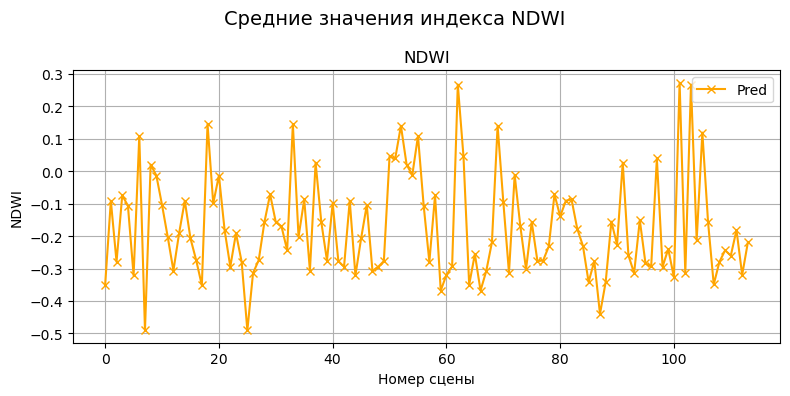

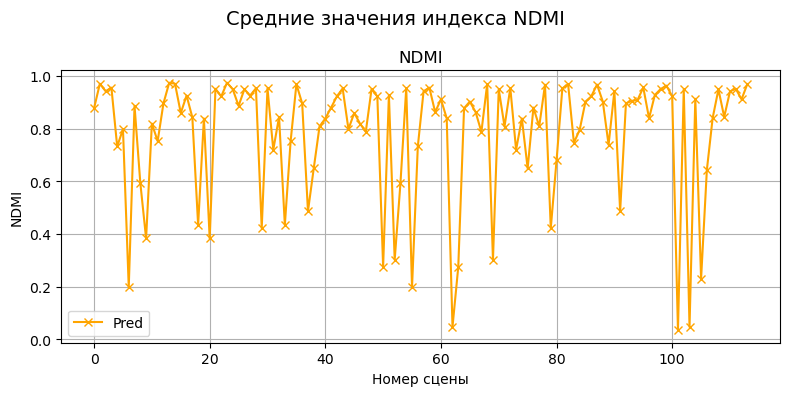

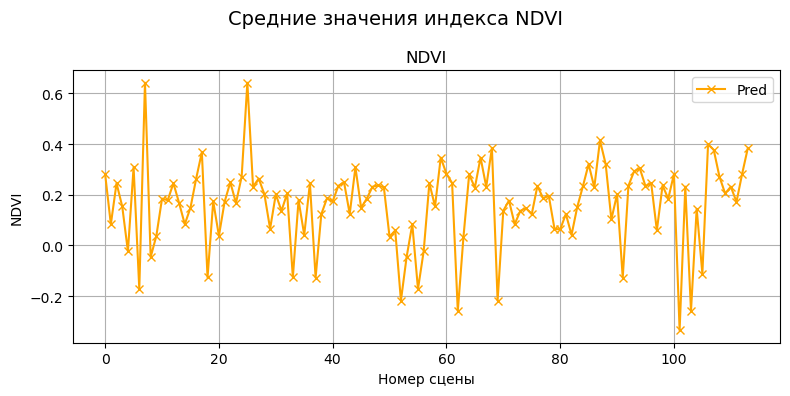

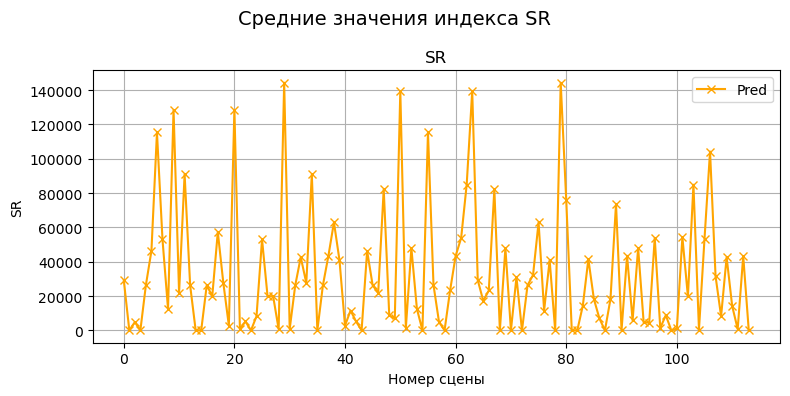

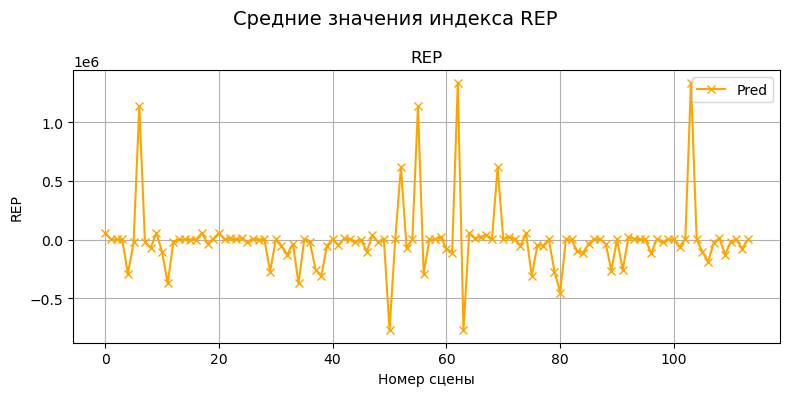

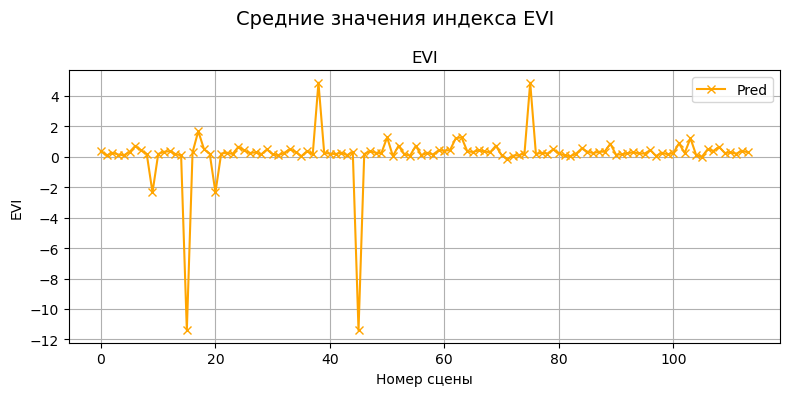

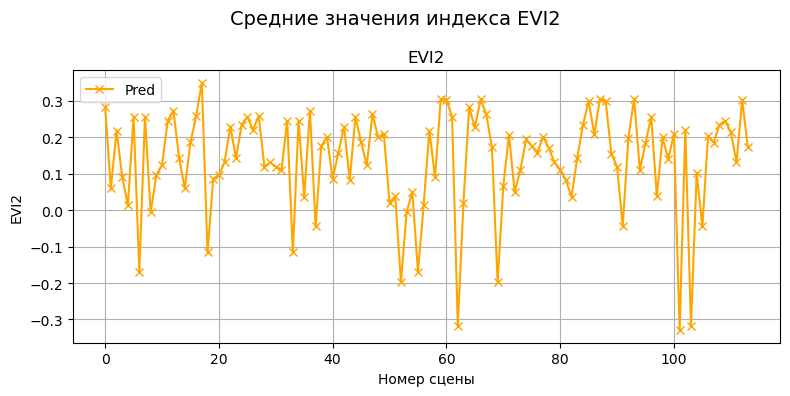

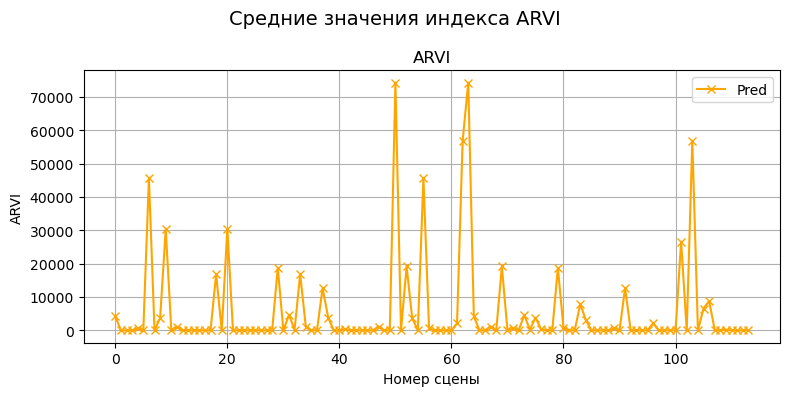

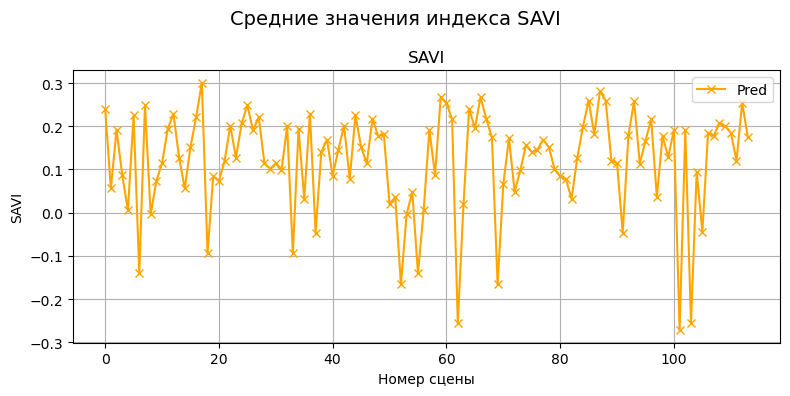

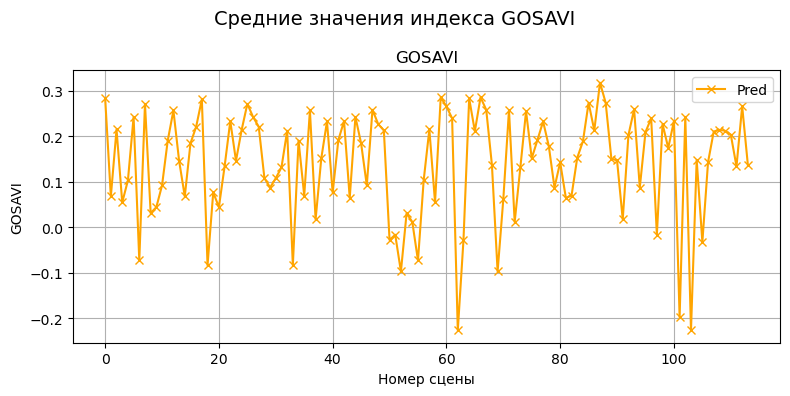

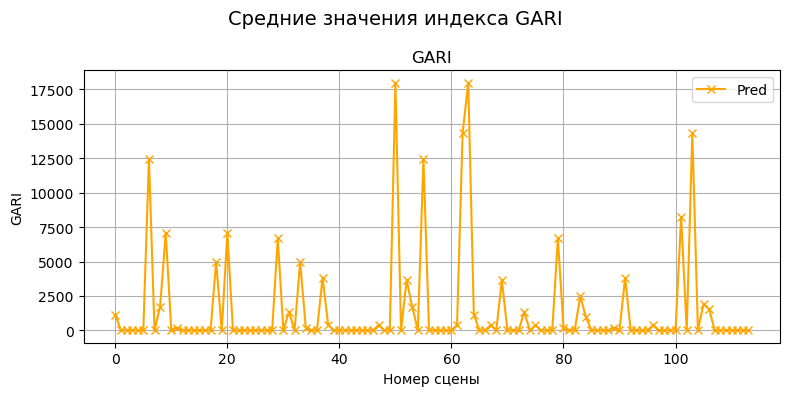

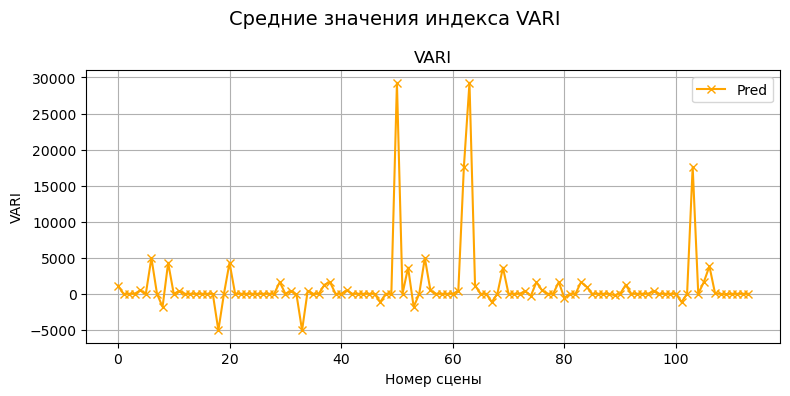

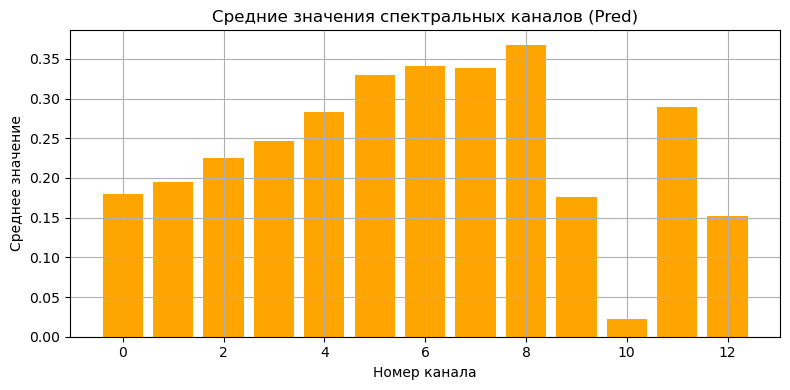


Средние значения каналов:
Канал 0: Pred=0.1797
Канал 1: Pred=0.1953
Канал 2: Pred=0.2249
Канал 3: Pred=0.2467
Канал 4: Pred=0.2834
Канал 5: Pred=0.3299
Канал 6: Pred=0.3404
Канал 7: Pred=0.3384
Канал 8: Pred=0.3675
Канал 9: Pred=0.1763
Канал 10: Pred=0.0226
Канал 11: Pred=0.2890
Канал 12: Pred=0.1520


In [17]:
import matplotlib.pyplot as plt

mean_indices_by_scene = {idx: {"Pred": []} for idx in indices}

for dct in index_means_list:
    for idx_name in indices:
        mean_indices_by_scene[idx_name]["Pred"].append(dct[idx_name])

print("\nСредние значения индексов (Pred):")
for idx_name in indices:
    pr_arr = mean_indices_by_scene[idx_name]["Pred"]
    if len(pr_arr) > 0:
        print(f"{idx_name}: Pred={np.mean(pr_arr):.4f}")
    else:
        print(f"{idx_name}: нет данных для Pred")

def plot_indices_in_row(mean_indices_by_scene, indices):
    for idx_name in indices:
        pr_vals = mean_indices_by_scene[idx_name]["Pred"]
        n_scenes = len(pr_vals)
        if n_scenes == 0:
            continue
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(pr_vals, marker='x', color='orange', label="Pred")
        ax.set_title(f"{idx_name}")
        ax.set_xlabel("Номер сцены")
        ax.set_ylabel(f"{idx_name}")
        ax.grid(True)
        ax.legend()
        plt.suptitle(f"Средние значения индекса {idx_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

plot_indices_in_row(mean_indices_by_scene, indices)

channel_means_pred = np.mean(channel_means_pred_list, axis=0) if channel_means_pred_list else None

if channel_means_pred is not None:
    x = np.arange(len(channel_means_pred))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x, channel_means_pred, color='orange', label="Pred")
    ax.set_title("Средние значения спектральных каналов (Pred)")
    ax.set_xlabel("Номер канала")
    ax.set_ylabel("Среднее значение")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    print("\nСредние значения каналов:")
    for i in range(len(channel_means_pred)):
        print(f"Канал {i}: Pred={channel_means_pred[i]:.4f}")

def plot_histogram(data_list, channel_idx, label):
    all_vals = []
    for data in data_list:
        ch_data = data[channel_idx].numpy().flatten()
        all_vals.append(ch_data)
    if not all_vals:
        return
    all_vals = np.concatenate(all_vals)
    plt.figure(figsize=(10, 5))
    plt.hist(all_vals, bins=100, alpha=0.7, label=label)
    plt.title(f"Гистограмма канала {channel_idx} ({label})")
    plt.xlabel("Значение")
    plt.ylabel("Количество пикселей")
    plt.legend()
    plt.show()
    print(f"Канал {channel_idx} ({label}): min={all_vals.min():.4f}, max={all_vals.max():.4f}")

#plot_histogram(pred_data_list, channel_idx=4, label="Pred")